<a href="https://colab.research.google.com/github/acastellanos-ie/TechMBA-SEP-2021-ST-DATA-ANALYTICS-TRACK/blob/main/text_classification_practice/text_classification_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab Configuration

**Execute this steps to configure the Google Colab environment in order to execute this notebook. It is not required if you are executing it locally and you have properly configured your local environment according to what explained in the Github Repository.**

The first step is to clone the repository to have access to all the data and files.

In [10]:
repository_name = "TechMBA-SEP-2021-ST-DATA-ANALYTICS-TRACK"
repository_url = 'https://github.com/acastellanos-ie/' + repository_name

In [2]:
! git clone $repository_url

Cloning into 'TechMBA-SEP-2021-ST-DATA-ANALYTICS-TRACK'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 82 (delta 43), reused 28 (delta 9), pack-reused 0
Unpacking objects: 100% (82/82), done.


Install the requirements (be aware that it could take a while)

In [3]:
! pip install -Uqqr $repository_name/requirements.txt

     |████████████████████████████████| 12.0 MB 3.9 MB/s 
     |████████████████████████████████| 3.4 MB 5.0 MB/s 
     |████████████████████████████████| 1.5 MB 39.7 MB/s 
     |████████████████████████████████| 10.4 MB 29.0 MB/s 
     |████████████████████████████████| 11.3 MB 53.5 MB/s 
     |████████████████████████████████| 385 kB 50.8 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.1 MB/s eta 0:00:44tcmalloc: large alloc 1147494400 bytes == 0x55c10c3c4000 @  0x7fd8f41be615 0x55c0d30c54cc 0x55c0d31a547a 0x55c0d30c82ed 0x55c0d31b9e1d 0x55c0d313be99 0x55c0d31369ee 0x55c0d30c9bda 0x55c0d313bd00 0x55c0d31369ee 0x55c0d30c9bda 0x55c0d3138737 0x55c0d31bac66 0x55c0d3137daf 0x55c0d31bac66 0x55c0d3137daf 0x55c0d31bac66 0x55c0d3137daf 0x55c0d30ca039 0x55c0d310d409 0x55c0d30c8c52 0x55c0d313bc25 0x55c0d31369ee 0x55c0d30c9bda 0x55c0d3138737 0x55c0d31369ee 0x55c0d30c9bda 0x55c0d3137915 0x55c0d30c9afa 0x55c0d3137c0d 0x55c0d31369ee
     |████████████████████████████████| 881.9 MB 16 kB/s 

Everything is set up properly! You can now move on to the practice code.

I do recommend you to restart the environment at this point to ensure that Google Colab is aware of the installed packages and their configuration (see image below).

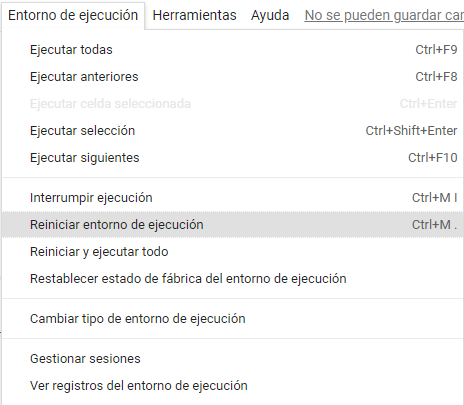

Go to the practice directory

In [11]:
%cd $repository_name/text_classification_practice

/content/TechMBA-SEP-2021-ST-DATA-ANALYTICS-TRACK/text_classification_practice


Ensure that you have the GPU runtime activated:

![](https://miro.medium.com/max/3006/1*vOkqNhJNl1204kOhqq59zA.png)

Now you have everything you need to execute the code in Colab

# Imports and Configuration

In [4]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Matplotlib conf
import matplotlib.pyplot as plt
%matplotlib inline

# Seaborn conf
import seaborn as sns
sns.set_palette(sns.color_palette("seismic"))

import sys

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import operator
import string
import nltk

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.naive_bayes import MultinomialNB


# Introduction


In this practice we will address a text classification problem: we will try to predict whether a given tweet is about a real disaster or not. In particular I propose you the scenario presented at the [Real or Not? NLP with Disaster Tweets Kaggle Competition.](https://www.kaggle.com/c/nlp-getting-started/leaderboard). 

To that, I am going to follow 2 different approaches:
- Apply traditional text classification methodologies based on "simple" Machine Learning models
- Apply state-of-the-art deep learning models

I have decided to give Deep Learning a try by applying the classification models explained in class.
However, the dataset we have at our disposal includes "only" 65K documents. We all know that to apply Deep Learning you need tons of data and weeks of training, right? 

Well, this in not true, or at least, this is not anymore completely true thanks to **Transfer Learning**. If you are training a huge model from scratch, you do need a lot of data and GPU time. Lucklily for us, these huge models are already pre-trained for many languages using large datasets (e.g. Wikipedia). All we have to do is to adapt these models to our particular domain. 65K documents are not enough to learn English, but they are definitely enough to learn the nuances of the dataset.

Cool, now we have a model adapted to the specific language in my dataset but the business case was to create a classifier. Why am I even doing all of this? In the traditional ML methodologies we were feeding our algorithms with a rather simple representation of our textual contents (The TF-IDF vectors). Now, thanks to the fine-tune pre-trained models, I can feed my classifier with a much more detailed and accurate representation of the input textual content. Therefore, it should be easier to the classifier to better categorize the textual content.


Summing up, my strategy will be:

1.   Use a pre-trained English Language Model trained over a large dataset as starting point.
2.   Adapt this language model to our domain. To that end, I will retrain the model to learn the particular aspects of the dataset.
3.   Create a Machine Learning Classifier on top of the dataset language model


**Side note: I have trained this model on Google Colab to be able to use a GPU.For this reason, I did not include anything about the configuration of the GPU or the installation of the required libraries. To execute it I do recommend you to update it to Google Colab**


# STEP 1: Loading and preprocessing the data

Before starting to play with the DeepLearning models we need to read, inspect and clean (if needed) the dataset. 

The dataset is provided in 2 different CSV files (one for training and another one for test)

In [12]:
training_df = pd.read_csv('nlp_disaster/data/train.csv', sep=',', index_col=0)
training_df = training_df.sample(frac=1).reset_index(drop=True)
print(training_df.head())

      keyword      location  \
0   blew%20up           NaN   
1      hijack           NaN   
2  eyewitness           NaN   
3  eyewitness  Rhode Island   
4        harm    WORLD WIDE   

                                                text  target  
0  @BenKin97 @Mili_5499 remember when u were up l...       1  
1  Swansea ?plot hijack transfer move for Southam...       0  
2  Remembering Pittsburgh Eyewitness History of S...       0  
3  WPRI 12 Eyewitness News Rhode Island set to mo...       0  
4  ÛÏFor I know the plans I have for youÛ decl...       0  


As you can see, the training set contains the dependent variable (1 or 0, real or not) as well as some independent variables: the actual text of the tweet and some of the metadata related

In [13]:
test_df = pd.read_csv('nlp_disaster/data/test.csv', sep=',', index_col=0)
print(test_df.head())

   keyword location                                               text
id                                                                    
0      NaN      NaN                 Just happened a terrible car crash
2      NaN      NaN  Heard about #earthquake is different cities, s...
3      NaN      NaN  there is a forest fire at spot pond, geese are...
9      NaN      NaN           Apocalypse lighting. #Spokane #wildfires
11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


The test set contains the same independent variables, but no label whatsoever. This is the common scenario proposed by Kaggle. You get a training set to create your models and then you have to use these models to predict over the test set.

## Inspecting the data

In this step I will try to make sense of the kind of data that we have. 

### Class distribution

The first thing I will do is to inspect the distribution of the target variable to check if we have an imbalace problem

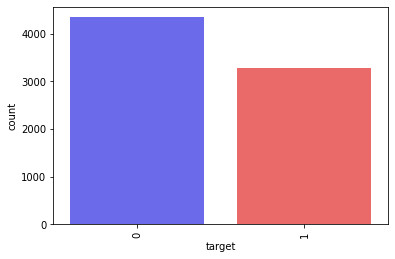

In [15]:
sns.countplot(x=training_df.target, order=[x for x, count in sorted(Counter(training_df.target).items(), key=lambda x: -x[1])], palette="seismic")
plt.xticks(rotation=90);

As seen in the figure, There are a slight difference between the number of tweets at each class but nothing to worry about.

# STEP 2: Traditional Machine Learning Models

Before starting the training process, we need to take care of some aspects related to the data format

We now split the dataset again for the creation and evaluation of the models into training and test


In [6]:
X_train = training_df[["text"]]
y_train = training_df[["target"]]
X_test = test_df[["text"]]


Labels are in string format. It is preferred to have them numerically encoded. To that end, sklearn provides a `LabelEncoder` to facilitate this encoding

In [20]:
# Hot encoding for the labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train.target.values)
target_labels = le.classes_
encoded_y_train = le.transform(y_train.target.values)


We then need to convert the textual content into numerical feature vectors (i.e., one-hot encoded vectors), applying the bags of words representation:

 - Assign an id to each word of the training set.
 - For each document `d`, label the occurrence or not of each word `w` and store it in `X[i, j]` as the value of feature `j` where `j` is the index of `w` in the dictionary

Sklearn has also some useful functions for this textual processing that we will make use of.

We are going to use the `CountVectorizer` for creating the feature vectors and the `TfidfTransformer` which returns the Document-Term Matrix with the terms weighted by means of their TF-IDF score.

In [28]:
one_hot_vect = CountVectorizer(binary=True)
train_features = one_hot_vect.fit_transform(X_train['text'])
test_features = one_hot_vect.transform(X_test['text'])
print(train_features.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


These representation might be improved by considering not just the binary appearance, but also the number of times that the word appears on a document:

- For each document `d`, count the number of occurrences of each word `w` and store it in `X[i, j]` as the value of feature `j` where `j` is the index of `w` in the dictionary

Other types of weighting strategines, such as TF-IDF can be also computed via sklearn.

In [30]:
count_vect = CountVectorizer()
train_features = count_vect.fit_transform(X_train['text'])
test_features = count_vect.transform(X_test['text'])

tfidf = TfidfTransformer(norm="l2")
train_text_tfidf_features = tfidf.fit_transform(train_features)
test_text_tfidf_features = tfidf.fit_transform(test_features)   

Now we have our dataset in the needed format that will allow us to create our baseline models

To train, evaluate and compare the models I've created a function `train_and_evaluate_classifier` that takes the training data, a classifier definition and a grid to optimize the classifier to train a predictive model.

In [34]:
def train_and_evaluate_classifier(X, yt, estimator, grid):
    """Train and Evaluate a estimator (defined as input parameter) on the given labeled data using accuracy."""
    
    # Cross validation
    from sklearn.model_selection import ShuffleSplit
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
      
    from sklearn.model_selection import GridSearchCV
    grid_search = GridSearchCV(estimator=estimator, cv=cv,  param_grid=grid, error_score=0.0, n_jobs = -1, verbose = 0)
    
    # Train the model over and tune the parameters
    print("Training model")
    grid_search.fit(X, yt)

    # CV-score
    print("Best score: %0.3f" % grid_search.best_score_)
    if len(grid) > 0:
        print("Best parameters set:")
        best_parameters = grid_search.best_estimator_.get_params()
        print(best_parameters)

    return grid_search

## LogReg Classifier

Logistic Regression is a simple algorithm that presents a good compromise between performance and simplicity for textual classification

In [35]:
from sklearn.linear_model import LogisticRegression
max_ent_grid= {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
max_ent_cls = train_and_evaluate_classifier(train_text_tfidf_features, encoded_y_train, LogisticRegression(max_iter=1000), max_ent_grid)

Training model
Best score: 0.804
Best parameters set:
{'C': 10, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Summing up, with traditional ML we have been able to achieve a performance around 80%. That's not bad, however I would like to give a try to some of the most advanced textual representations.

As you will see, thanks to some libraries it is not so difficult/scary as it might seem.

# STEP 3: Recurrent Neural Nets (RNN)

In class we have discussed about this kind of Deep Learning models. RNNs apply a DL architecture focused on modeling sequential information. In particular, Long Sort Term Memory Networks, a subtype of RNNs, are especially well suited for text. Since they are able to capture short term as well as long term relationships, commonly present in textual information.

In more detail we are going to make use of the [AWD-LSTM](https://arxiv.org/abs/1708.02182) model: one of the top-performing approaches in the text classification literature. Do not worry, you do not need to implement by yourself the model in the paper. Luckily for us, their authors have already implemented it in the fast.ai library


## Fast AI

To facilitate the training of this deep learning approach, I will make use of the [fast.ai library](https://www.fast.ai/). In particular, the [`text`](https://docs.fast.ai/text.core.html) module of the fast.ai library contains all the necessary functions. Specifically:

- [`text.data`](https://docs.fast.ai/text.data.html) contains the Functions and transforms to help gather text data in a `Datasets`,
- [`text.learner`](https://docs.fast.ai/text.learner.html) contains helper functions to quickly create a language model or an text classifier.

For more information about the library and how to apply it to text classification, please refer to the related [chapter](https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb) of the fast.ai book



## Training a classifier model


To create my model I am going to apply the following steps:

1. Fine-tuning an [AWD-LSTM](https://arxiv.org/abs/1708.02182) model to create a language model based on our data.
1. Building a classifier based on the learned language model

### Reading and viewing the data

First let's import everything we need for text.

In [7]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.text.all import *

### Getting your data ready for modeling


In the same way that we needed to use the Vectorizers in sklearn to create the textual representation to fed the machine learning models, we need to properly format the input textual data so we can feed the DeepLearning model.

fast.ai provides some helpful loaders to format the input data to the format required by the Deep Learning Model.

In [8]:
# Language model data
df_all = pd.concat([training_df, test_df])

dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),
    get_x=ColReader('text'),
    splitter=RandomSplitter(0.1)).dataloaders(df_all, bs=64, seq_len=40)

dls_lm.show_batch(max_n=5)

,text,text_
0,xxbos xxmaj new xxup ran report from the frontlines of human rights abuses and forest destruction for fashion . : http : / / t.co / xxunk xxbos xxmaj summer heat drives xxunk to xxmaj calgary xxunk ~ 35 http,xxmaj new xxup ran report from the frontlines of human rights abuses and forest destruction for fashion . : http : / / t.co / xxunk xxbos xxmaj summer heat drives xxunk to xxmaj calgary xxunk ~ 35 http :
1,is why i want her to be better - which means death xxunk her . xxmaj most of us are n't heroes we are survivors xxbos xxup rt xxunk : xxmaj first accident in years . xxmaj turning onto xxmaj,why i want her to be better - which means death xxunk her . xxmaj most of us are n't heroes we are survivors xxbos xxup rt xxunk : xxmaj first accident in years . xxmaj turning onto xxmaj xxunk
2,xxbos xxunk xxunk it would nt turn into a sandstorm if riot gave a good answer . xxmaj instead they gave dumb xxunk . xxmaj at least new client is there xxbos xxmaj swear to god if they make xxunk,xxunk xxunk it would nt turn into a sandstorm if riot gave a good answer . xxmaj instead they gave dumb xxunk . xxmaj at least new client is there xxbos xxmaj swear to god if they make xxunk play
3,wake of anthrax lab mishaps http : / / t.co / xxunk via @usatoday xxbos # pakistan # news # xxup xxunk xxmaj city xxmaj news : xxmaj man electrocuted xxmaj from xxmaj our xxmaj xxunk xxup xxunk : a,of anthrax lab mishaps http : / / t.co / xxunk via @usatoday xxbos # pakistan # news # xxup xxunk xxmaj city xxmaj news : xxmaj man electrocuted xxmaj from xxmaj our xxmaj xxunk xxup xxunk : a man
4,of xxmaj xxunk xxmaj california : xxmaj time2015 - 08 - 06 xxunk xxup utc2015 - 08 - 05 xxunk xxunk … http : / / t.co / xxunk xxbos xxmaj ignition xxmaj knock ( detonation ) sensor - senso,xxmaj xxunk xxmaj california : xxmaj time2015 - 08 - 06 xxunk xxup utc2015 - 08 - 05 xxunk xxunk … http : / / t.co / xxunk xxbos xxmaj ignition xxmaj knock ( detonation ) sensor - senso xxmaj


We are not applying any data cleaning given that we need the original text in the tweet. 

Think about it, we are trying to update the pre-trained language model with the data in our dataset. LMs are trained by asking the model to predict the most likely next word/s, given an input sentece (e.g., The dog is ...). If we remove the stopwords or we stem the words, the LM is not going to be able to learn from the actual input sentence (e.g., The dog is ... after stopword removal and lematization will be transformed to [dog, be]).

### Fine-tuning

We can now use the `data_lm` object I created earlier to fine-tune a pretrained language model. [fast.ai](http://www.fast.ai/) has an English model with an [AWD-LSTM architecture](https://arxiv.org/abs/1708.02182) available. To use it, we can create a learner object that will directly create the model, download the pretrained weights and be ready for fine-tuning.

Neural nets in general, and the AWD_LSTM model in particular, are well know for having a huge number of hyperparameters to optimize. 

I am deliberately using the default values that fast.ai implements. fast.ai is well know for their superconvergent models that are able to train in just a few steps. This is done through their thoughtful research about initializations, regularization, optimizers and batch normalization. All of these findings are implmented in their default values, so, for most of the tasks, we can safely use them.

There is though an hyperparameter that requires careful optimization, the learning rate. Learning rate refers to the "speed" at which the optimizer is updating the neural net parameters in the backpropagation step. Pick a large learning rate and your NN will never converge. Pick a small rate and you will wait forever to see your NN achive a good performance or to see your NN stuck at a local minima. 

I will make use of the `lr_find` method in fast.ai to make sense of the values that are optimal for my data



In [9]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(valley=0.006025596056133509)

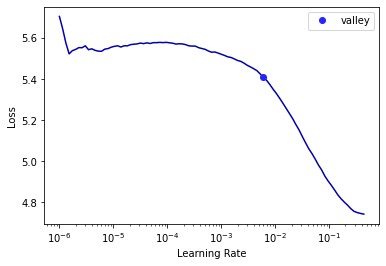

In [10]:
learn.lr_find(start_lr=1e-6, end_lr=1)

What we see in this figure is the projection of how the model will perform based on different learning rates.

We have to choose a value that is approximately in the middle of the sharpest downward slope. Why?! Well, for a more intuitive explanation you can check this [blog post](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html). Basically, the reason is:

> [...] the minimum value is already a bit too high, since we are at the edge between improving and getting all over the place. We want to go one order of magnitude before, a value that's still aggressive (so that we train quickly) but still on the safe side from an explosion.


This is given as an indication by the LR Finder tool, so let's try it.



In [11]:
learn.fit_one_cycle(5, 0.006)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.451122,3.719669,0.386614,41.250744,00:20
1,3.527723,3.230710,0.441960,25.297619,00:19
2,3.073171,3.095925,0.460348,22.107670,00:19
3,2.848215,3.056097,0.466866,21.244478,00:19
4,2.739223,3.052638,0.467278,21.171122,00:19


After just only one epoch we have a pretty good result (i.e., remember that we are still fine-tuning the language model, so guessing right about one third of times which is going to be the next word is a pretty good model). It seems that the default values of the library based on the super-convergence approach are just fine. So, I am not going to pay attention to them anymore. In a more developed solution, we could spend some time trying to optimize them.

At this point it is important to explain what are we actually training. As I explained before, we have a pre-trained model of the English language. By pretrained, we mean nothing more the Neural Net has a set of weights already learned.
This model is quite deep, it has many number of layers with millions of parameters (a.k.a. weights) to learn. It has been posible to train such a huge model, because the entire Wikipedia was used. 

However, we only have a small bunch of news reports to adapt/fine-tune the model to our domain. Fine-tuning is nothing more than modifying a little bit the weights of the model, so they reflect the particular relationships in our data. But, since our dataset is rather small, if we try to retrain all the layers in the model, we will completely destroy it (the model will catastrophically forget everything learned from Wikipedia). 

If you think about it, it makes sense, the deeper layers in the model are actually learning the basic aspects of the language, while shallow layers are in charge of more high-level relationships. We do not want to change the deeper layers. Basic language relationships are the same in our dataset than in the entire English language (e.g., verb tenses, subject-object relationships). What we actually want to modify is the last layers of the model in charge of learning the high level relationships (e.g. Obama does something). Well, that's exactly what the default training method in fast.ai is doing: It freezes the deeper layers so you do not modify them while you are fine-tuning your model. How convenient, right? 

In the previous step, we have fine-tuned the LM to the particular content of our dataset. To do this, we just trained the last layers in our model to avoid forgetting everything. Now that our model is in a *stable* state (it has learned from our data without losing what learned from Wikipedia), we can further train our model by unfreeze all the layers.

The rationale is the following: we can slightly change the weights of all the layers so even the most basic aspects of the language can be redefined according to our data (e.g. Napoleonic wars Wikipedia pages can learn the model that France<-->invade is a likely outcome; however, I do not expect to read anything about a French invasion in the HuffPost). 

It has been experimentally proven that this process can improve the performane of Deep Learning models (see this [Howard and Ruder's paper](https://arxiv.org/pdf/1801.06146.pdf) for more details). We have to be extremely careful with this process, otherwise we will ruin all our work. To that end, I have reduced my learning rate by an order of magnitude



In [12]:
learn.unfreeze()
learn.fit_one_cycle(2, 0.006/10)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.611673,2.960556,0.485945,19.308704,00:21
1,2.453926,2.950360,0.490701,19.112839,00:21


Cool! Only after some epochs and my model has been improved.


To understand what our language model is learning, you can run the [`Learner.predict`](https://docs.fast.ai/learner.html#Learner.predict) method and specify the number of words you want it to guess.

In [13]:
TEXT = "Haha South Tampa"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [14]:
print("\n".join(preds))


Haha South Tampa City Football Bowl Back To The Summer Football Game NOW i AM SCREAMING AT THE GAME WHERE IS MY PARTY
Haha South Tampa & & Tampa Customers Businesses are deluged with invoices . Make yours stand out with colour or shape and it 's likely to rise to the top of the pay ' pile .


It doesn't make much sense (we have a tiny vocabulary here and didn't train much on it) but note that it respects basic grammar (which comes from the pretrained model) while it has adapted the conversation to the content of the dataset.



I could futher train or experiment with more hyperparameters, but since the language model is not the final outcome and the LM seems good enough, I will move on to the classification step.


We can save the model for later uses. We need to save the encoder (the part that given a textual content creates the representation) which is the only part of the model needed for classification in the next section (i.e., the other part is the decoder in charge of translating the textual representation back to the text again).

In [ ]:
learn.save_encoder('ft_enc_extended')

### Building a classifier


We now have the language model fine-tuned to our dataset. The next step is create and fine-tune the classification model.

To recap, a language model predicts the next word of a document, so it doesn't need any external labels. The classifier, however, needs an annotated dataset 
containing the texts to classify and their labels (`disaster` and `not-disaster` in our case)

In [15]:
dls_class = DataBlock(
    blocks=(
        TextBlock.from_df('text', # We take the textual information from the column "text" in the dataset
                          seq_len=40, # Maximum tweet length
                          vocab=dls_lm.vocab # We use the same vocabulary representation than the one used for the LM
                          ), 
            CategoryBlock), # Because we will use these data for classification
    get_x=ColReader('text'),
    get_y=ColReader('target'),
    splitter=RandomSplitter(0.2)).dataloaders(training_df, bs=64)

dls_class.show_batch(max_n=10)

,text,category
0,xxbos _ \n▁ xxrep 5 ? xxup retweet \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow xxup all xxup who xxup rt \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup xxunk \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup gain xxup with \n▁ xxrep 7 ? \n▁ xxrep 5 ? xxup follow ? xxunk # xxup xxunk \n▁ # xxup ty,0
1,xxbos . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : . : xxup rt xxunk : # xxunk \n\n xxmaj indian xxmaj army xxunk _ http : / / t.co / xxunk g,0
2,xxbos xxup info xxup s. xxup wnd : xxunk / 6 . xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 .,0
3,xxbos xxup info xxup r. xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup wnd : xxunk / 5 . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup xxunk . xxup tmp : 10 . xxup xxunk : xxunk .,0
4,xxbos xxmaj no # news of # hostages in # xxmaj libya \n\n http : / / t.co / xxunk \n\n▁ # xxmaj india # terrorism # xxmaj africa # xxup ap # xxup ts # xxup nri # xxmaj news # xxup trs # xxup tdp # xxup bjp http : / / t.co / xxunk,1
5,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,1
6,xxbos xxmaj no # news of # hostages in # xxmaj libya \n\n http : / / t.co / xxunk \n\n▁ # xxmaj india # terrorism # xxmaj africa # xxup ap # xxup ts # xxup nri # xxmaj news # xxup trs # xxup tdp # xxup bjp http : / / t.co / xxunk,1
7,xxbos xxmaj no # news of # hostages in # xxmaj libya \n\n http : / / t.co / xxunk \n\n▁ # xxmaj india # terrorism # xxmaj africa # xxup ap # xxup ts # xxup nri # xxmaj news # xxup trs # xxup tdp # xxup bjp http : / / t.co / xxunk,1
8,xxbos xxmaj rare xxunk into # terror and xxmaj how to fight it http : / / t.co / xxunk # xxmaj cameroon # xxup usa # xxmaj xxunk # xxup xxunk # xxup fr # xxmaj nigeria # xxup uk # xxmaj africa # xxup de # xxup ca # xxup au # xxup jp,1
9,xxbos xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxup xxunk xxmaj please # xxup rt,0


It's now time to actually create the classifier taking our fine-tuned encoder. For this step we need the `data_clas` object we created earlier.

For this step, I will use again the default values in fast.ai to create a classification model. In this case, I will use the `text_classifier_learner`. We need to also tell the classifier that we want to use the fine-tuned encoder that we have just learned.

In [23]:
learn = text_classifier_learner(dls_class, AWD_LSTM, drop_mult=0.8, metrics=[accuracy,FBeta(beta=1)]).to_fp16()
learn.freeze()

SuggestedLRs(valley=0.002511886414140463)

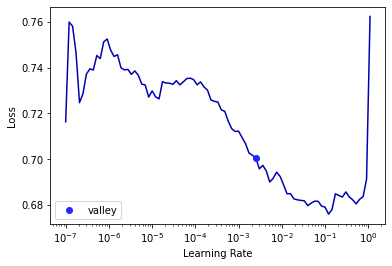

In [18]:
learn.lr_find()

Thanks to fast.ai super-convergence strategies, I think that just one epoch should be enough. Let's see

In [24]:
learn.fit_one_cycle(5, 0.0025)

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.644005,0.519607,0.745072,0.688103,00:11
1,0.602142,0.512314,0.754271,0.705047,00:09
2,0.583348,0.507607,0.760841,0.705977,00:09
3,0.574417,0.498282,0.765440,0.709046,00:09
4,0.568060,0.498759,0.768725,0.714286,00:09


In [ ]:
learn.save('lstm_1')

We can futher train this model. As in the language modeling training, we have just trained the last layers of the model, we can gradually unfreeze the rest of the model and train it together.

In this case I will not unfreeze all the model at a time, but in different steps. This gradual unfreezing has been experimentally proven to improve the training process (again, check Howard and Ruder's paper).

In [25]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(0.0025/(2.6**4),0.0025))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.569279,0.496428,0.767411,0.708402,00:10


In [ ]:
learn.save('lstm_2')

In [26]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(0.0025/2/(2.6**4),0.0025/2))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.550322,0.494386,0.765440,0.685463,00:10


In [ ]:
learn.save('lstm_3')

In [27]:
learn.unfreeze()
learn.fit_one_cycle(20, slice(0.0025/10/(2.6**4),0.0025/10))

epoch,train_loss,valid_loss,accuracy,fbeta_score,time
0,0.537444,0.492504,0.765440,0.687664,00:10
1,0.542032,0.489606,0.769382,0.695048,00:10
2,0.537170,0.484806,0.771353,0.693122,00:10
3,0.528381,0.479660,0.779238,0.716695,00:10
4,0.524478,0.472106,0.789750,0.734219,00:10
5,0.521812,0.468515,0.791721,0.730213,00:10
6,0.506595,0.466338,0.791721,0.736929,00:10
7,0.502867,0.465831,0.791721,0.739523,00:10
8,0.494384,0.463192,0.795664,0.738436,00:10
9,0.488925,0.459131,0.795664,0.742336,00:10


In [ ]:
learn.save('lstm_4')


As can be seen in the results, our model is now offering accuracies up to 85%! Better than those we had with LR, RF or SVM.

In order to have a full report of this model performance, I will ask the model to offer me all the predictions and inspect the confusion matrix and the classification report

In [30]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)


In [29]:
from sklearn.metrics import classification_report

print(classification_report(targets, predictions))

              precision    recall  f1-score   support

           0       0.81      0.86      0.84       871
           1       0.80      0.73      0.76       651

    accuracy                           0.81      1522
   macro avg       0.80      0.80      0.80      1522
weighted avg       0.81      0.81      0.80      1522



As can be seen in both the confusion matrix and in the classification report, the model is better not only in terms of accuracy, but also in its performance for all the classes when compared to the non Deep Learning models. Something that I care about since the start.



Finally, saving the model object to reuse it.

In [ ]:
learn.save('final_lstm_model')

# STEP 4: Transformers. Is attention all you need for Text Classification?

In this third solution I want to go a step beyond to apply the most advanced methodologies in the NLP state-of-the-art: Transformers. We have already discussed Transformers in class, as well as their advantages over other methodologies. 

There is still some controversy about what technique is better suited for Text Classification (and NLP in general): RNNs or Transformers. Different research works suggest different experimental results. Nevertheless, it seems that Transformer-based models are starting to outperform RNN-based systems. Let's check what happens in our problem. 

Using Transformes might sound scary (many hyperparameters, you have to deal with tensor, shapes, transform your data....). However, there are a number of libraries and wrappers that will make your life easier (or at least less miserable). In particular, in this solution I will make use of two of them, which I strongly recommend you to use if you want to experiment with these ideas:

 - [HuggingFace](https://huggingface.co/): They provide under the [`transformers`](https://github.com/huggingface/transformers) library a large number of pre-trained state-of-the-art pretrained NLP models together with some handy functions to load them, fine-tune them and put them into practice.
 - [ktrain](https://github.com/amaiya/ktrain): Python library that provides a higher-level wrapper that facilitates the use of Deep Learning based NLP models (HuggingFace models among them).

Let the fun begin!

**Disclaimer:This solution is based on this [post](https://towardsdatascience.com/text-classification-with-hugging-face-transformers-in-tensorflow-2-without-tears-ee50e4f3e7ed) as well as in the [ktrain](https://github.com/amaiya/ktrain) library documentation**



In [1]:
# Install an old version of sklearn for compatibility with the ktrain library
# ! pip install scikit-learn==0.21

import tensorflow as tf
import ktrain
from ktrain import text

## Create the Transformer Model

In this step I will take the dataset, preprocess it (via ktrain) and create a Text Classifier based on a Transformer model. This process follows a similar intuition to what we already did with fast.ai in the other markdown, although it is not exactly the same.

We will start again with a Language Model pre-trained using a huge dataset: a model that speaks English. The model in particular is the well-know BERT. We already explained the basic rationale of BERT in class, but just as a reminder: it applies the idea of Self-Attention (instead of an RNN architecture) to learn the sequential information of textual contents. If you want to know more, let me refer you again to this great blog post: http://jalammar.github.io/illustrated-bert/.

As we also did in the other markdown, we have to now fine-tune this model: Retrain the model to our specific dataset and task. In more detail, the BERT model provides a encoder block with pre-trained weights which gives BERT a general understanding of English. The BERT encoder block will look at each input tweet as a whole, producing an output that contains an understanding of the textual content of the tweet. This representation is then feed to a Text classifier. Thanks to ktrain, this process only involves a handful of lines of code.

In [14]:
trn, val, preproc = text.texts_from_df(training_df,'text',preprocess_mode='bert',label_columns='target',verbose=True, maxlen=32) # Process the input tweets based on the BERT encoder

model = text.text_classifier('bert', trn, preproc=preproc) # Create a text classifier that uses the BERT-based representations created before

learner = ktrain.get_learner(model, train_data=trn, val_data=val,  batch_size=128) # Creates the learning process to fine-tune bert and train the classifier.

['not_target', 'target']
      not_target  target
6613         1.0     0.0
5684         1.0     0.0
3012         1.0     0.0
3987         0.0     1.0
2179         0.0     1.0
['not_target', 'target']
      not_target  target
6206         0.0     1.0
5198         1.0     0.0
3720         0.0     1.0
4328         0.0     1.0
4277         1.0     0.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 32
done.


## Train the Model

It is now time to actually train (fine-tuning + train the text classifier) the model. This process might take a while. BERT is huge and memory-hungry. Consequently, it is pretty slow for both training and prediction. 

Since our dataset is not very large, you can train the model in a reasonable amount of time if you have a GPU at your disposal (if you don't just use Google Colab or another platform offering GPUs as I did. Do not try to train this model in your laptop if you do not want to potentially wait for hours). 

Nevertheless, because of this complexity, BERT is not very suitable for production environments. In this sense, I recommend you to take a look to DistilBERT. DistillBERT is a “distilled” (a.k.a. reduced) version of BERT that is smaller and faster while retaining most of BERT’s accuracy. Check this blog post from HuggingFace for more details on DistillBERT and the whole idea of Knowledge Distillation: https://medium.com/huggingface/distilbert-8cf3380435b5).

There are many other pre-trained models that HuggingFace provides. You can check the entire Model zoo in the following link: https://huggingface.co/transformers/pretrained_models.html.

The first thing to do is to find the optimal learning rate (as we did with our LSTM model). As you can see the ktrain interface is quite similar to the fast.ai interface.


simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/2
54/54 [==============================] - 62s 757ms/step - loss: 0.6334 - accuracy: 0.6154
Epoch 2/2
54/54 [==============================] - 33s 615ms/step - loss: 13.1041 - accuracy: 0.5394


done.
Visually inspect loss plot and select learning rate associated with falling loss


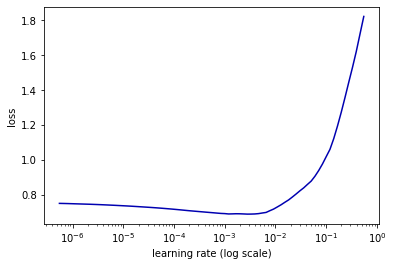

In [15]:
learner.lr_find(show_plot=True, max_epochs=2)

As we already now, we want a learning rate which is more or less in the middle of the steeper slope of the loss function. In our case is somewhere about 1e-4.

I will train the model for a some of epochs and see what happens.

In [16]:
learner.autofit(lr=1e-4, # Learning Rate 
                epochs=5, # Number of epochs to train the model
                early_stopping=2, # If the model does not improve after 2 epochs, we stop the training
                reduce_on_plateau=1,  # If the model does not improve aftear 1 epoch, we reduce the learning rate
                monitor='val_loss', # Metric to monitor the peformance of the model (loss computed on the validation dataset)
                checkpoint_folder='transformer_cpt_1' # After each epoch we store a checkpoint of the model
                )



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/5
54/54 [==============================] - 68s 925ms/step - loss: 0.4900 - accuracy: 0.7688 - val_loss: 0.3944 - val_accuracy: 0.8307
Epoch 2/5
54/54 [==============================] - 46s 857ms/step - loss: 0.3441 - accuracy: 0.8609 - val_loss: 0.3923 - val_accuracy: 0.8281
Epoch 3/5
54/54 [==============================] - ETA: 0s - loss: 0.2546 - accuracy: 0.9013
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 5e-05 (if not early_stopping).
54/54 [==============================] - 47s 871ms/step - loss: 0.2546 - accuracy: 0.9013 - val_loss: 0.4186 - val_accuracy: 0.8451
Epoch 4/5
54/54 [==============================] - ETA: 0s - loss: 0.1561 - accuracy: 0.9407
Epoch 00004: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
Restoring model weights from the end of the best epoch: 2.
54/54 [==============================] - 48s 886ms/step - loss: 0.1561 - ac

The first thing to notice is that the model takes a lot of time to train! Way more than the LSTM model. This is one of the donwsides of using a Transformer model. I only recommend you to use them if they do provide a significant improvement compared to the LSTM model. 

I do encourage you to try different paramaters (e.g., learning rate, model) to see if you can improve the performance


In [ ]:
learner.save_model('transformer_1') # Saving the trained model

We are going to now unfreeze the whole model to allow its retraining. As with the LSTM model, be careful! If you are too much aggressive with this re-training you will end up ruining the model.

In this sense, I have reduced the learning rate by a magnitude order and try to retrain for one more epoch an check the performance

In [17]:
learner.unfreeze()
learner.fit_onecycle(1e-4/10, 1, checkpoint_folder='transformer_cpt_2')



begin training using onecycle policy with max lr of 1e-05...
54/54 [==============================] - 69s 937ms/step - loss: 0.2461 - accuracy: 0.9067 - val_loss: 0.4066 - val_accuracy: 0.8425


In [ ]:
learner.save_model('transformer_2') # Store the final model


## Evaluate and Inspect the Model

Large Deep Learning models are well-know for being quite black-boxy. However, in this section, I would like to provide you with some tools to evaluate and analyze them.

First I will create the confussion matrix to understand the performance of the model and to check the accuracy and F-measure.


In [18]:
learner.validate(class_names=['Regular Tweet','Disaster Tweet'])

                precision    recall  f1-score   support

 Regular Tweet       0.85      0.89      0.87       444
Disaster Tweet       0.83      0.78      0.81       318

      accuracy                           0.84       762
     macro avg       0.84      0.83      0.84       762
  weighted avg       0.84      0.84      0.84       762



array([[394,  50],
       [ 70, 248]])

The model is a little bit better on detecting regular tweets; I guess that this is because we have more of those. Anyhow, it works pretty well for both classes in terms of accuracy and F-measure.


If you want to better understand how the model is working ktrain provides some useful techniques.

You can examine the validation tweets about which the model was the most wrong about (i.e., the top losses).

In [19]:
learner.view_top_losses(n=10, preproc=preproc)

----------
id:41 | loss:5.22 | true:not_target | pred:target)

[CLS] . pot ##us # strategic ##pati ##ence is a strategy for # genocide ; refugees ; id ##p internally displaced people ; horror ; etc . https : / / [SEP]
----------
id:48 | loss:4.97 | true:not_target | pred:target)

[CLS] sas ##sy city girl country hu ##nk stranded in smoky mountain snow ##storm # ao ##ms http : / / t . co / z ##d ##j ##2 ##hy ##f [SEP]
----------
id:178 | loss:4.61 | true:not_target | pred:target)

[CLS] @ cnn the end of times are upon us . famine war death plague . the presence is growing stronger . [SEP]
----------
id:527 | loss:4.59 | true:not_target | pred:target)

[CLS] survival kit whistle fire starter wire saw cree torch emergency blanket s knife - full re ##u _ http : / / t . co / 2 ##oro ##yu ##ny [SEP]
----------
id:57 | loss:4.34 | true:not_target | pred:target)

[CLS] teen disaster prepared ##ness event in van nu ##ys august 11 @ 5 : 30 ##pm http : / / t . co / fx ##ux ##9 ##8 ##7 ##v [SEP]
-

ktrain, actually provides an `explain` method to know that. It allows you to inspect a given tweet and visualize which words contributed the most on deciding the final prediction. We will need a forked version of the **eli5** library that supportes TensorFlow Keras, so let's install it first.

In [20]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1


And call the `explain` function

In [21]:
predictor = ktrain.get_predictor(learner.model, preproc)

predictor.explain("[CLS] the government is concerned about the population explosion and the population is concerned about the government explosion . - joe moore [SEP]")

Thanks to this library and the `explain` method you can understand why the model is failing.

For example, the tweet

  `[CLS] the government is concerned about the population explosion and the population is concerned about the government explosion . - joe moore [SEP]` 

has been categorized as disaster when it is not about a disaster.

We can understand that the problem is that the model is focusing on the word explosion, which is categorized as highly related to the disaster class. While it seems to be usually right, explosions are a strong indicators of disasters, in this situation the model is not able to understand the the word explosion is being used ironically.